In [1]:
import os, random, time, datetime, re
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.preprocessing import label_binarize
import torch.nn as nn

# Προετοιμασία για αναπαραγωγιμότητα
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2025-05-19 09:56:16.562897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747648576.744097      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747648576.797715      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [2]:
# Προετοιμασία για lemmatization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def cleaning(text):
    text = text.lower()
    text = re.sub(r'@\w+', '<user>', text)
    text = re.sub(r'#\w+', '<hashtag>', text)
    text = re.sub(r'http\S+|www\S+', '<url>', text) 
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    slang_dict = {
        r'\bur\b': 'your', r'\bu\b': 'you', r'\br\b': 'are',
        r'\bbrb\b': 'be right back', r'\bbtw\b': 'by the way',
        r'\blol\b': 'laughing out loud', r'\bomg\b': 'oh my god',
        r'\btmr\b': 'tomorrow', r'\bppl\b': 'people',
        r'\bidk\b': 'i do not know', r'\bimo\b': 'in my opinion',
        r'\bimho\b': 'in my humble opinion', r'\bwanna\b': 'want to',
        r'\bgonna\b': 'going to', r'\bgotta\b': 'got to',
        r'\bcuz\b': 'because', r'\bcoz\b': 'because', r'\bnvm\b': 'nevermind',
        r'\bya\b': 'yes', r'\byeah\b': 'yes', r'\blmk\b': 'let me know',
        r'\bttyl\b': 'talk to you later'
    }
    for k, v in slang_dict.items():
        text = re.sub(k, v, text)

    text = re.sub(r"\bi['’]?m\b", "i am", text)
    text = re.sub(r"\bdon['’]?t\b", "do not", text)
    text = re.sub(r"\bdoesn['’]?t\b", "does not", text)
    text = re.sub(r"\bhaven['’]?t\b", "have not", text)
    text = re.sub(r"\bhasn['’]?t\b", "has not", text)
    text = re.sub(r"\bcan['’]?t\b", "can not", text)
    text = re.sub(r"\bur\b", "you are", text)
    text = re.sub(r"\bure\b", "you are", text)

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Load datasets
train_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/val_dataset.csv")
test_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/test_dataset.csv")

# Balanced subsample
subset_size = len(train_df) // 4
samples_per_class = subset_size // 2
df_0 = train_df[train_df.Label == 0].sample(samples_per_class, random_state=42)
df_1 = train_df[train_df.Label == 1].sample(samples_per_class, random_state=42)
train_df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
# Εφαρμογή preprocessing
train_texts = [cleaning(text) for text in train_df.Text.tolist()]
val_texts = [cleaning(text) for text in val_df.Text.tolist()]
test_texts = [cleaning(text) for text in test_df.Text.tolist()]

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class BERTDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_attention_mask=True,
            return_tensors='pt'
        )
        item = {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten()
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


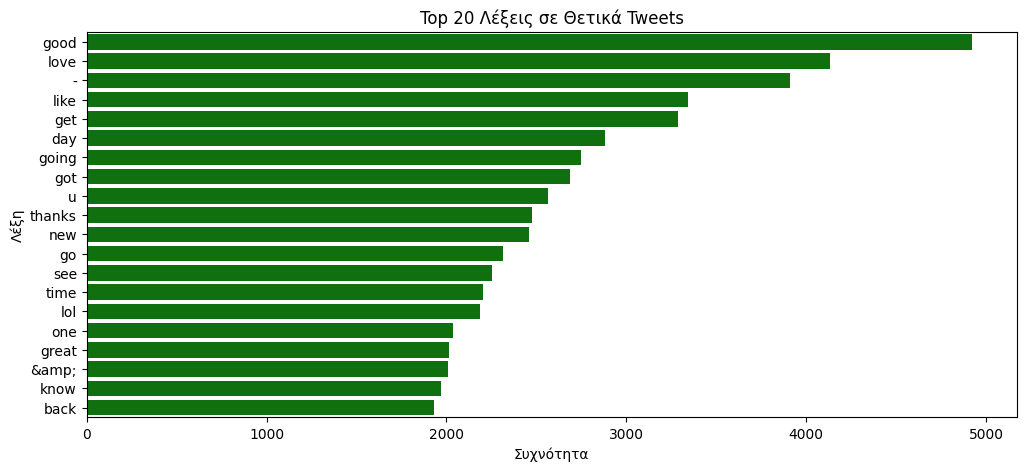

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


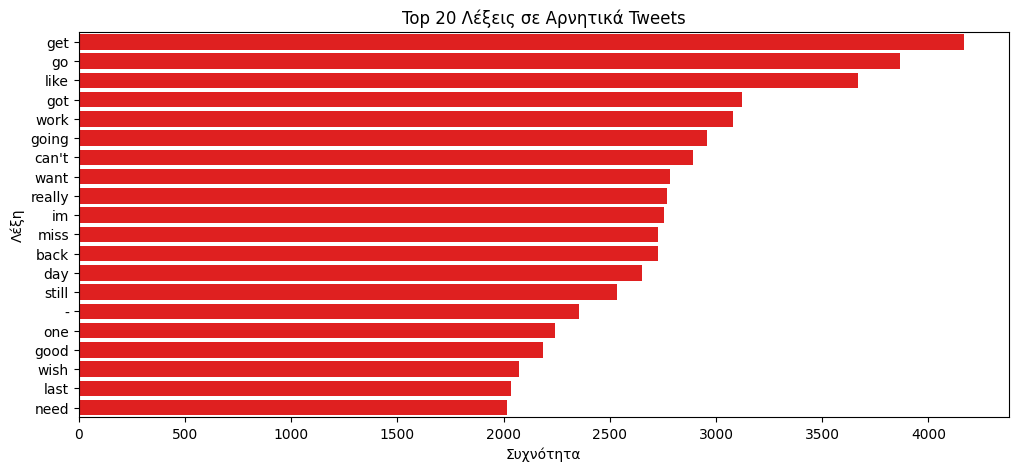

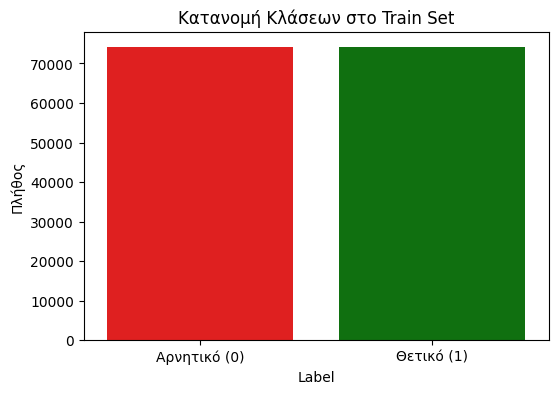

In [6]:
# Κατέβασμα stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Φόρτωση δεδομένων
train_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/train_dataset.csv")

# Καθαρισμός lowercase (ή βάλε εδώ το cleaning)
train_df["clean_text"] = train_df["Text"].str.lower()

# Διαχωρισμός σε θετικά/αρνητικά
positive_words = " ".join(train_df[train_df['Label'] == 1]['clean_text']).split()
negative_words = " ".join(train_df[train_df['Label'] == 0]['clean_text']).split()

# Αφαίρεση stopwords
positive_filtered = [w for w in positive_words if w not in stop_words]
negative_filtered = [w for w in negative_words if w not in stop_words]

# --- Bar Plots Συχνοτήτων ---
freq_pos = Counter(positive_filtered)
freq_neg = Counter(negative_filtered)

top_pos = dict(freq_pos.most_common(20))
top_neg = dict(freq_neg.most_common(20))

plt.figure(figsize=(12, 5))
sns.barplot(x=list(top_pos.values()), y=list(top_pos.keys()), color="green")
plt.title("Top 20 Λέξεις σε Θετικά Tweets")
plt.xlabel("Συχνότητα")
plt.ylabel("Λέξη")
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=list(top_neg.values()), y=list(top_neg.keys()), color="red")
plt.title("Top 20 Λέξεις σε Αρνητικά Tweets")
plt.xlabel("Συχνότητα")
plt.ylabel("Λέξη")
plt.show()

# --- Κατανομή Labels ---
label_counts = train_df['Label'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=["red", "green"])
plt.xticks([0, 1], ["Αρνητικό (0)", "Θετικό (1)"])
plt.ylabel("Πλήθος")
plt.title("Κατανομή Κλάσεων στο Train Set")
plt.show()


In [7]:
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

In [8]:
train_ds = BERTDataset(train_df.Text.tolist(), train_df.Label.tolist(), tokenizer)
val_ds = BERTDataset(val_df.Text.tolist(), val_df.Label.tolist(), tokenizer)
test_ds = BERTDataset(test_df.Text.tolist(), None, tokenizer)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

model = BERTClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
criterion = nn.CrossEntropyLoss()
total_steps = len(train_loader) * 4
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=1):
    best_acc = 0


    # Για learning curves
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            _, preds = torch.max(outputs, dim=1)
            total_correct += torch.sum(preds == labels)
            total_loss += loss.item()

            loop.set_postfix(loss=loss.item())

        train_acc = total_correct.double() / len(train_loader.dataset)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc.item())

        # --- Validation ---
        model.eval()
        val_preds, val_labels = [], []
        val_loss_total, val_correct = 0, 0

        with torch.no_grad():
            for batch in val_loader:
                ids = batch["input_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                output = model(ids, mask)
                loss = criterion(output, labels)
                val_loss_total += loss.item()

                _, preds = torch.max(output, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_correct += torch.sum(preds == labels)

        val_acc = accuracy_score(val_labels, val_preds)
        val_losses.append(val_loss_total / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_bert_model.pt")

    print(f"Best Validation Accuracy: {best_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [10]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=2
)

Epoch 1/2: 100%|██████████| 4638/4638 [30:36<00:00,  2.53it/s, loss=0.151]


Train Acc: 0.8286 | Val Acc: 0.8494


Epoch 2/2: 100%|██████████| 4638/4638 [30:34<00:00,  2.53it/s, loss=0.0497]


Train Acc: 0.8735 | Val Acc: 0.8540
Best Validation Accuracy: 0.8540


In [11]:
model.load_state_dict(torch.load("best_bert_model.pt", weights_only=True))

model.eval()

# Predict on test
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        output = model(ids, mask)
        _, preds = torch.max(output, dim=1)
        test_preds.extend(preds.cpu().numpy())

# Submission
test_df["Label"] = test_preds
test_df[["ID", "Label"]].to_csv("submission.csv", index=False)
print("submission.csv saved!")

# Validation metrics
val_preds = []
val_labels = val_df["Label"].tolist()
with torch.no_grad():
    for batch in val_loader:
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        output = model(ids, mask)
        _, preds = torch.max(output, dim=1)
        val_preds.extend(preds.cpu().numpy())

print("Validation Accuracy:", accuracy_score(val_labels, val_preds))
print("Precision:", precision_score(val_labels, val_preds, average='weighted'))
print("Recall:", recall_score(val_labels, val_preds, average='weighted'))
print("F1 Score:", f1_score(val_labels, val_preds, average='weighted'))

submission.csv saved!
Validation Accuracy: 0.8540428342296443
Precision: 0.8541285492485496
Recall: 0.8540428342296443
F1 Score: 0.8540339370100135


Computing ROC: 100%|██████████| 1325/1325 [02:37<00:00,  8.40it/s]


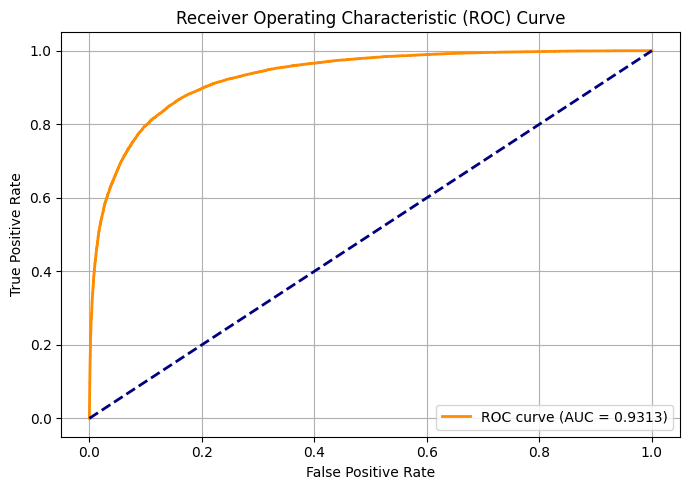

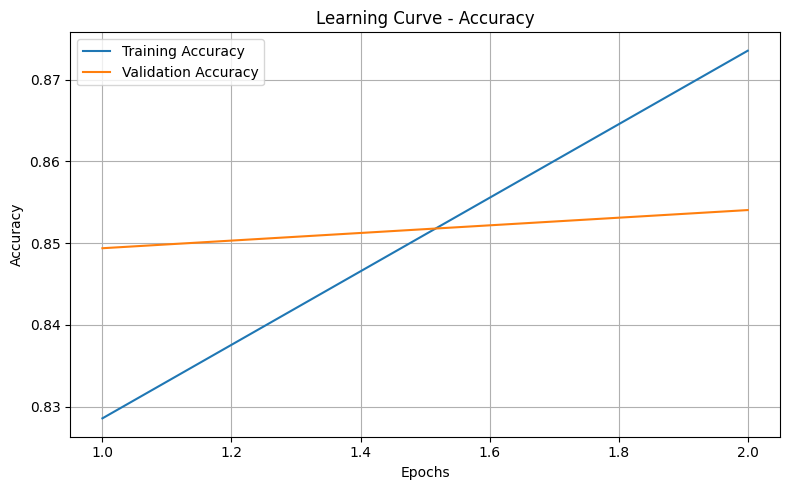

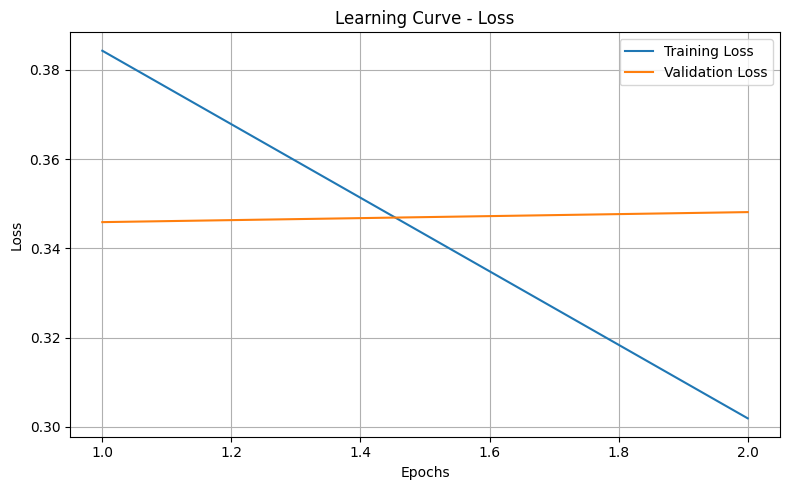

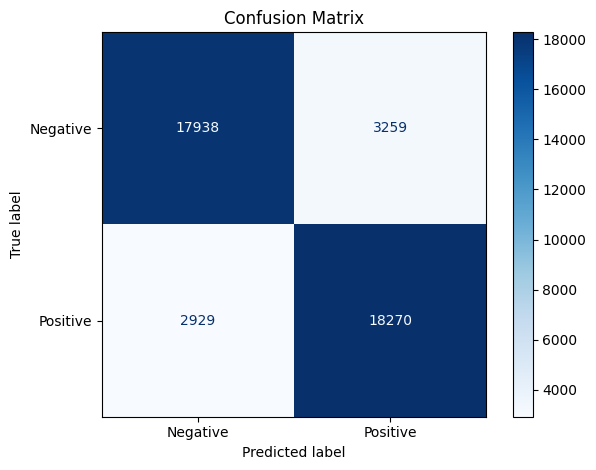

In [12]:
# Assume model, val_loader, val_df, train_losses, val_losses, train_accuracies, val_accuracies already exist

# 1. ROC Curve
val_true = val_df["Label"].tolist()
y_val_bin = label_binarize(val_true, classes=[0, 1]).ravel()

y_probs = []
model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Computing ROC"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1
        y_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(y_val_bin, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()

# 2. Learning Curves

# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_accuracy.png")
plt.show()

# Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_loss.png")
plt.show()

# 3. Confusion Matrix

val_preds_final = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        val_preds_final.extend(preds.cpu().numpy())

cm = confusion_matrix(val_true, val_preds_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()